## Import thư viện

In [36]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import cv2

In [37]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.callbacks import ModelCheckpoint

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Activation

## Đọc dữ liệu

### Dữ liệu huấn luyện

In [38]:
path = "../../data/train/Fish_Dataset" # đường dẫn đến thư mục chứa dữ liệu
classes = [i for i in os.listdir(path) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [39]:
data = [] # mảng chứa dữ liệu
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

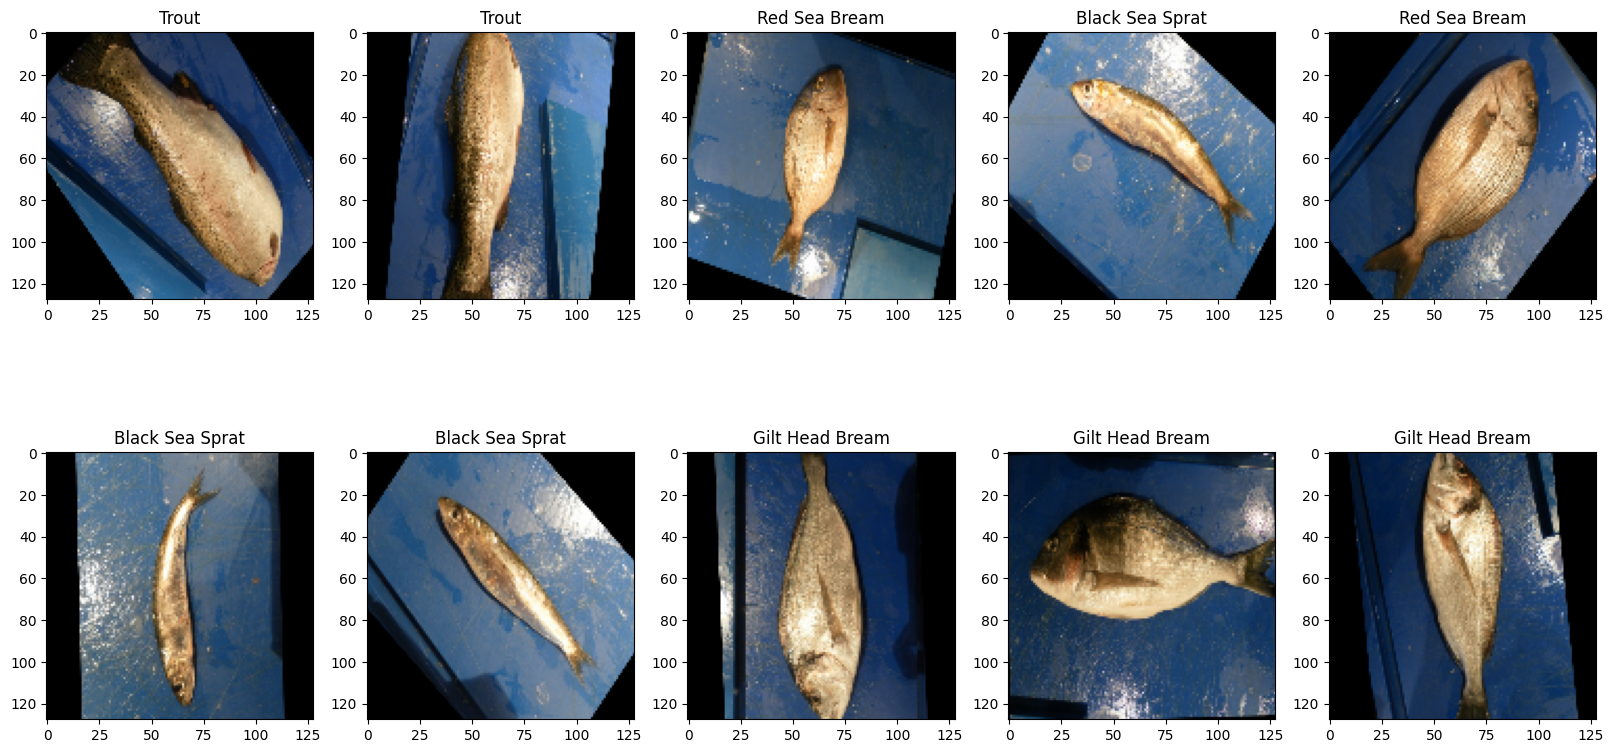

In [40]:
# hiện thị một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [41]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [42]:
# chuấn hóa label thành dạng số
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [43]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(9000, 128, 128, 3)

In [44]:
# biến đổi label thành one-hot encoding
labels = tf.keras.utils.to_categorical(labels, num_classes=9)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

#### Chia dữ liệu Train và Validation

In [45]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((7200, 128, 128, 3), (1800, 128, 128, 3), (7200, 9), (1800, 9))

In [46]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800, 7: 800, 8: 800}

### Dữ liệu Test

In [47]:
data_test = []
path = "../../data/test/NA_Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data_test.append([img, folder])

In [48]:
# shuffle data_test
import random
random.shuffle(data_test)

In [49]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [50]:
# chuấn hóa label
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [51]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
test_images = np.array(test_images)
test_images = test_images.astype('float32') / 255.0
test_images.shape

(430, 128, 128, 3)

In [52]:
# biến đổi label thành one-hot encoding
test_labels  = tf.keras.utils.to_categorical(test_labels , num_classes=9)
test_labels 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Xây dựng model

In [53]:
h = train_images.shape[1] # chiều cao của ảnh
w = train_images.shape[2] # chiều rộng của ảnh
c = train_images.shape[3] # số kênh màu của ảnh

In [ ]:
# tạo model
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(h, w, c)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary() # hiển thị thông tin model

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_59 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_52 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 59, 59, 64)      

In [ ]:
callbacks = [ModelCheckpoint('../model/model1.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')]
history = model.fit(train_images ,train_labels, batch_size=32, epochs=15, verbose=1, validation_data=(val_images, val_labels), callbacks= [callbacks])

Epoch 1/15
225/225 [==============================] - ETA: 0s - loss: 1.0713 - accuracy: 0.6374
Epoch 1: val_loss improved from inf to 8.55307, saving model to model1.hdf5
225/225 [==============================] - 222s 960ms/step - loss: 1.0713 - accuracy: 0.6374 - val_loss: 8.5531 - val_accuracy: 0.1111
Epoch 2/15
225/225 [==============================] - ETA: 0s - loss: 0.3925 - accuracy: 0.8744
Epoch 2: val_loss improved from 8.55307 to 4.24824, saving model to model1.hdf5
225/225 [==============================] - 221s 981ms/step - loss: 0.3925 - accuracy: 0.8744 - val_loss: 4.2482 - val_accuracy: 0.3494
Epoch 3/15
225/225 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9310
Epoch 3: val_loss improved from 4.24824 to 1.07440, saving model to model1.hdf5
225/225 [==============================] - 228s 1s/step - loss: 0.2226 - accuracy: 0.9310 - val_loss: 1.0744 - val_accuracy: 0.6761
Epoch 4/15
225/225 [==============================] - ETA: 0s - loss: 0.14

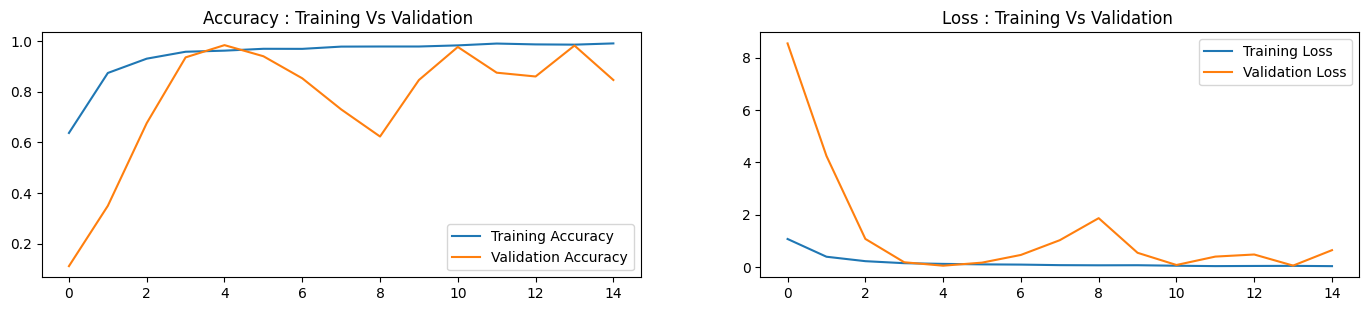

In [ ]:
# trực quan hóa quá trình train
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(15), accuracy, label='Training Accuracy')
plt.plot(range(15), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training Vs Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show();

In [55]:
model = load_model('../model/model1.hdf5') # load model đã lưu

### Đánh giá mô hình trên tập validation

In [ ]:
y_pred = model.predict(x=val_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(val_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

57/57 [==============================] - 18s 324ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

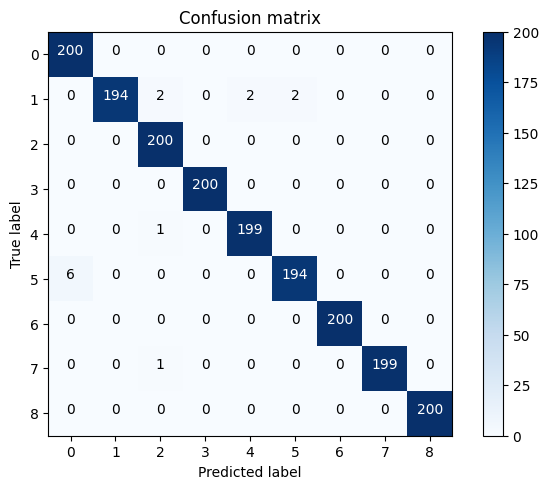

In [ ]:
classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(val_labels.argmax(axis=1), y_pred.argmax(axis=1), target_names=le.classes_));

                    precision    recall  f1-score   support

   Black Sea Sprat       0.97      1.00      0.99       200
   Gilt Head Bream       1.00      0.97      0.98       200
   Hourse Mackerel       0.98      1.00      0.99       200
        Red Mullet       1.00      1.00      1.00       200
     Red Sea Bream       0.99      0.99      0.99       200
          Sea Bass       0.99      0.97      0.98       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       1.00      0.99      1.00       200
             Trout       1.00      1.00      1.00       200

          accuracy                           0.99      1800
         macro avg       0.99      0.99      0.99      1800
      weighted avg       0.99      0.99      0.99      1800



### Kiểm thử mô hình trên tập dữ liệu khác

In [ ]:
y_pred = model.predict(x=test_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(test_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

14/14 [==============================] - 2s 118ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

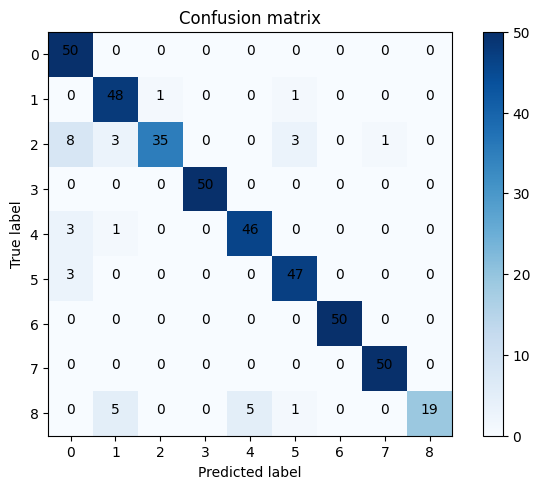

In [ ]:
y_pred = model.predict(x=test_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(test_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)



classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# Đánh giá model trên tập test
print(classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1), target_names=le.classes_));

                    precision    recall  f1-score   support

   Black Sea Sprat       0.78      1.00      0.88        50
   Gilt Head Bream       0.84      0.96      0.90        50
   Hourse Mackerel       0.97      0.70      0.81        50
        Red Mullet       1.00      1.00      1.00        50
     Red Sea Bream       0.90      0.92      0.91        50
          Sea Bass       0.90      0.94      0.92        50
            Shrimp       1.00      1.00      1.00        50
Striped Red Mullet       0.98      1.00      0.99        50
             Trout       1.00      0.63      0.78        30

          accuracy                           0.92       430
         macro avg       0.93      0.91      0.91       430
      weighted avg       0.93      0.92      0.92       430



---

## Trực quan hình ảnh được xử lý qua từng lớp trong mạng

In [57]:
img = images[:100]

In [58]:
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

successive_feature_maps = visualization_model.predict(img)

layer_names = [layer.name for layer in model.layers]

4/4 [==============================] - 1s 94ms/step


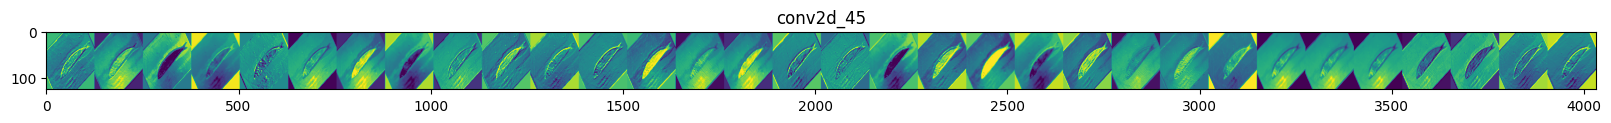

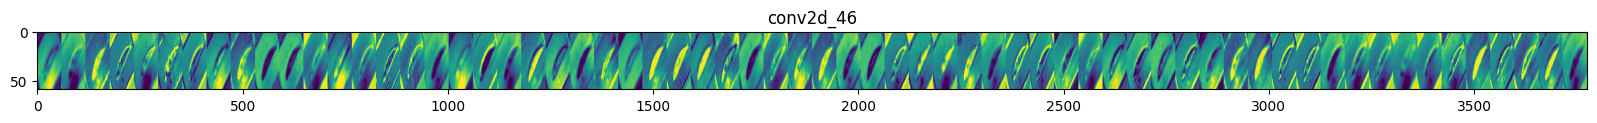

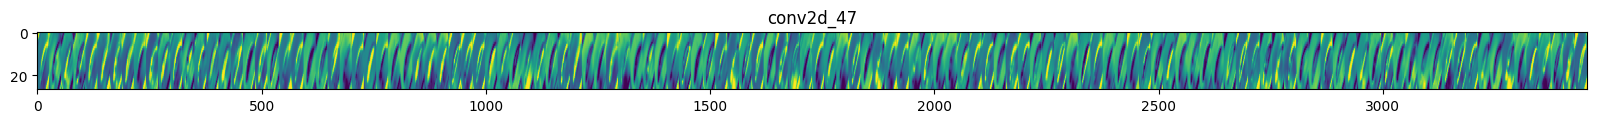

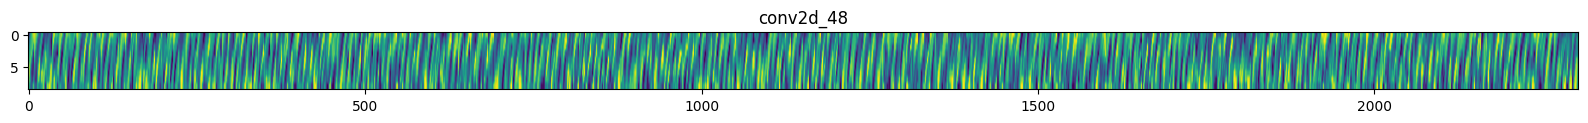

In [59]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if 'conv' in layer_name:

        n_features = feature_map.shape[-1] 
        size = feature_map.shape[1]  
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            img = feature_map[0, :, :, i]
            img -= img.mean()
            img /= img.std()
            img *= 64
            img += 128
            img = np.clip(img, 0, 255).astype('uint8')
            display_grid[:, i * size:(i + 1) * size] = img 

        # scale = 1000/ n_features
        plt.figure(figsize=(20,0.75))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')